# Machine learning (AIC-4101C)

1. [Linear discriminant analysis](#Linear-Discriminant-Analysis)
1. [Nearest neighbor](#Nearest-neighbor)
1. [$k$-nearest neighbors](#$k$-nearest-neighbors)
1. [Evaluating models](#Evaluating-models)

In [11]:
from mllab import *

First, let's create a dataset consisting of observations from three different distributions.

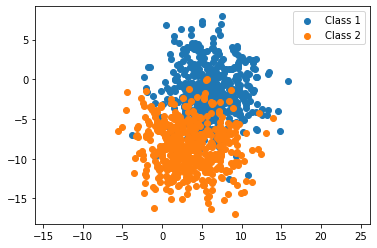

In [20]:
from sklearn.datasets import make_blobs

data, target = make_blobs(n_samples=1000, centers=2, n_features=2, cluster_std=3.1)    
plotXY(data, target)

## Linear Discriminant Analysis
Linear Discriminant Analysis, LDA for short, is a statistical method used to seperate $n$ observations into $K$ classes using a linear combination of parameters. It is central to the field of dimensionality reduction and may be used as a classifier as we shall see here. It is similar to logistic regression insofar as it uses a continous independent variable to explain a categorical dependent variable. However, the main assumption of LDA that sets it apart from other tools in regression analysis is the assumption of normality of the independent clusters of data. An extra assumption LDA makes is equal variance for all clusters, such that the parameters of the estimation are the means $\mu_k$ of the clusters, $k=1...K$ and the common variance $\sigma^2$.

>How many parameters are we estimating ?


> Scatter the data using **plotXY** and plot the frontiere of the linear discriminant analysis using  the **plot_frontiere** function.

**Hint** : Use the classifier implemented in scikit-learn [LinearDiscriminantAnalysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html).

<AxesSubplot:>

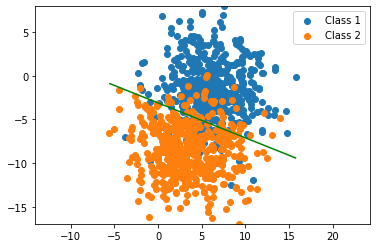

In [21]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA().fit(data,target)

ax = plt.gca()
ax = plotXY(data, target, ax=ax)
plot_frontiere(lda, data=data, ax=ax)

Consider the complete likelihood $L\left(\mu_1,...,\mu_K,\sigma\right)=\prod_{i=1}^n \prod_{k=1}^K \left(f_{\mu_k,\sigma}\left(X_i\right)\right)^{1_{y_i=k}}$, where $f_{\mu,\sigma}\left(x\right)=\frac{1}{\sqrt{2\pi}\sigma}e^{-\frac{\left(x-\mu\right)^2}{2\sigma^2}}$. The second product is a fake product, because every observation $X_i$ belongs to a determined class $k$, and so only one power in the product will be equal to $1$, all the rest are equal to $0$ and do not actually factor in the product. The log-likelihood can then be computed and is given by $$\log L\left(\mu_1,...,\mu_K,\sigma\right)=\sum_{i=1}^n \sum_{k=1}^K 1_{yi=k} \left(-\log\left(\sqrt{2\pi}\right)-\log\left(\sigma\right)-\frac{\left(x-\mu_k\right)^2}{2\sigma^2}\right)$$

> Based on the previous lesson on the logistic regression, what is the loss function of this classification model ?

The parameters maximizing this function are $\hat{\mu}_k=\frac{\sum_{i=1}^n X_i 1_{y_i=k}}{\sum_{i=1}^n 1_{y_i=k}}$ for all $k$ and $\hat{\sigma}=\frac{1}{n-K}\sum_{i=1}^n \sum_{k=1}^K \left(X_i-\mu_k\right)^2 1_{yi=k}$

>What is the complexity (the number of operations needed) of such a classification ? What is the cost of the learning phase ? What about prediction ?

## Nearest neighbor
The nearest neighbor classification is one of the simplest supervised learning methods. Let a training set be composed of $N$ observations $X = \{ x^{(1)}, \dots, x^{(N)} \}$ of dimension $d$ and its associated classes $y = \{ C_1, \dots, C_N \}$. **The classification of an unknown observation $x$ is done by finding the class of its closest neighbor** (usually against the euclidian distance) among the obervations $X$.

>Compute the complexity (the number of operations needed) of a classification. What is the cost of the learning phase ?

>Compute the size of the model (the number of parameters to save in memory to make a classification). Compare with the linear discriminant analysis.

In [14]:
# This is not the only way of doing it

from operator import itemgetter

class kNn:
    
    def __init__(self, k=1, dist=None, weight=None):
        self.X = None
        self.y = None
        
        self.k = k

        if dist is None:
            dist = (lambda a,b : np.sqrt(((np.array(a) - np.array(b))**2).sum())) # Euclidean distance
        self.dist = dist
        
        if weight is None:
            weight = (lambda d : 1)
        self.weight = weight

    def fit(self, X, y):
        self.X = X
        self.y = y        
        return self
    
    def __classify__(self, x):

        # Compute all the distances and weigths in an array : distances = (index, distance, weigth)
        distances = list()

        for i, x_i in enumerate(self.X):
            d = self.dist(x, x_i)
            distances.append([i, d, self.weight(d)])

        # Sort the array by the distances (increasing order) and keep the k-first index
        nn = sorted(distances, key=itemgetter(1))
        knn = np.array(nn[:self.k])
        
        # keep indexes
        knn_ind = knn[:, 0].astype(int)

        # vote
        vote = list()
        labels = np.unique(self.y[knn_ind])
        for label in labels:
            vote.append(sum((self.y[knn_ind] == label)*knn[:, 2]))

        # take the most vote-weighted class        
        label_knn = labels[np.argmax(vote)]

        return label_knn

    def predict(self, X):
        return np.array([self.__classify__(x) for x in X])

> Look at the function **map_regions** and plot the data and the classification regions for two different distances (the [Manhattan](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.spatial.distance.cityblock.html) and Euclidean distances for example).

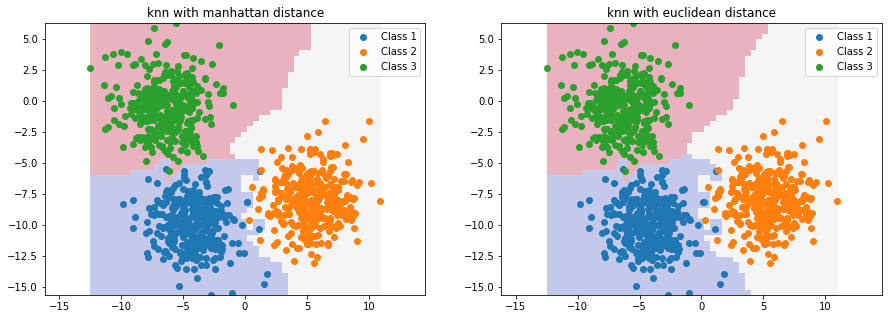

In [15]:
from scipy.spatial.distance import cityblock

data, target = make_blobs(n_samples=1000, n_features=2, cluster_std=2)     

fig, ax = plt.subplots(1, 2, figsize=(15,5))

for ax_, (d_name, dist) in zip(ax, (('manhattan', cityblock), ('euclidean', None))):
    knn = kNn(dist=dist)
    knn.fit(data, target)

    plotXY(data, target, ax=ax_)
    map_regions(knn, data, num=50, ax=ax_)
    ax_.set_title('knn with {} distance'.format(d_name))

## $k$-nearest neighbors
The nearest neighbor method is not robust to variation of data. To palliate that, we use $k$-nearest neighbors : instead of looking just at the closest point, we look for the $k$ closest points. The class chosen at the end is the majority class (voting phase) among those $k$ neighbors.

Several algorithms exist to find the $k$ closest points. The simplest version, linear, is :
- **Input** : a point $x$ unknown and a list of points $X = \{ x^{(1)}, \dots, x^{(N)} \}$
- **Initialization** : let $L$ be the list of the $k$ first elements of $X$, sorted by their distance to the point $x$ (obviously in an ascending order).
- **For** each point $x^{(i)} \in X$, **If** it is closer to $x$ than the last element of $L$ **then**:
  - Delete the last element of $L$
  - Insert $x^{(i)}$ into $L$ in a way that it is still sorted.
- **Return** $L$

Some more complex variants are available in [sklearn.neighbors](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.neighbors).

>Adapt your classifier to be a $k$-nearest neighbors classifier.

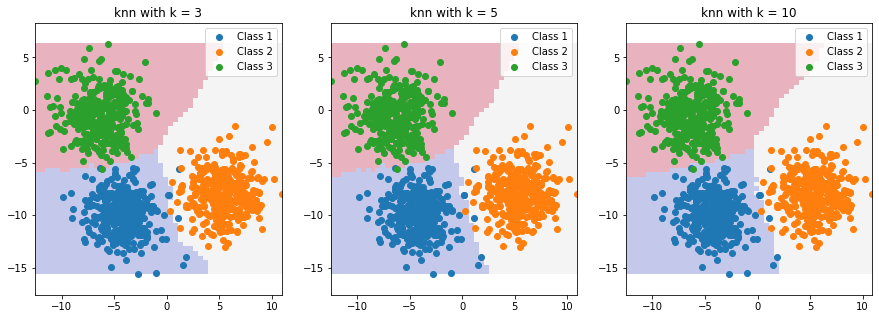

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))

for ax_, k in zip(ax, (3, 5, 10)):
    knn = kNn(k)
    knn.fit(data, target)

    plotXY(data, target, ax=ax_)
    map_regions(knn, data, num=50, ax=ax_)
    ax_.set_title('knn with k = {}'.format(k))

To reduce the influence of the most distant neighbors (and so containing less information), we introduce weights in the vote phase. For each neighborg $x^{(i)}$, the weight associated is $$w_i = \exp \left\{ - \frac{D(x, x^{(i)})}{\sigma^2} \right\}$$ where $\sigma$ is an hyperparameter to determine and $D$ the distance chosen for classification.

>Adapt your previous classifier to use weigth during the vote.

In [17]:
# Done

>Plot the mapping regions of your classification with the same data. Comment.

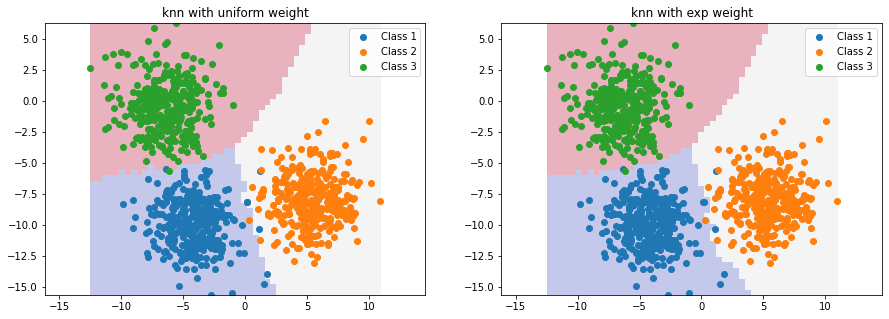

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

for ax_, (w_name, weight) in zip(ax, (('uniform', None), ('exp', lambda d : np.exp(-d)))):
    knn = kNn(5, weight=weight)
    knn.fit(data, target)
    plotXY(data, target, ax=ax_)
    map_regions(knn, data, num=50, ax=ax_)
    ax_.set_title('knn with {} weight'.format(w_name))

## Evaluating models

In order to evaluate our models, we will split the data into two subsets : the training set and the test set. Usually a between 70 to 80% of the data should be used for the learning (training) phase.

>Compare the computation times and the accuracies of the linear discriminant analysis and the $k$-nn method for several sizes of data sets. Comment.

**Hint** : Check the documentation of the functions [accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) and [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) of scikit-learn.

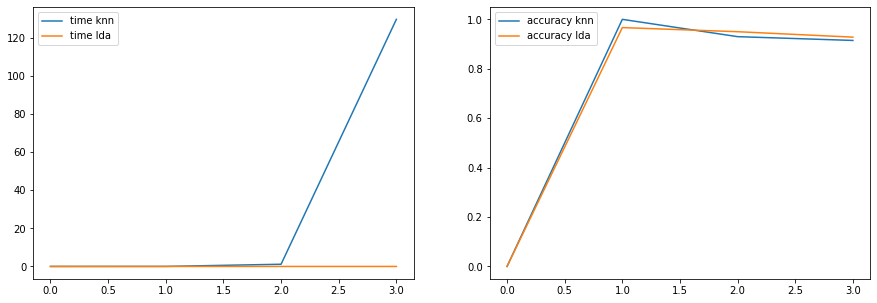

In [19]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from time import time

t = list()
accuracy = list()

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

for n in (10, 100, 1000, 10000):
    data, target = make_blobs(n_samples=n, n_features=2, cluster_std=2)
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3)

    for clf in kNn(3), LDA():
        clf.fit(X_train, y_train)
        start = time()
        y_hat = clf.predict(X_test)
        t.append(time() - start)
        accuracy.append(accuracy_score(y_test, y_hat))
        
ax[0].plot(t[::2], label='time knn')
ax[0].plot(t[1::2], label='time lda')
ax[0].legend()

ax[1].plot(accuracy[::2], label='accuracy knn')
ax[1].plot(accuracy[1::2], label='accuracy lda')
ax[1].legend()